Only for use within Bosch Research and Advance Engineering. Integration in products, distribution or other cession to third parties is not permitted without explicit consent of the responsible SPF within CR which delivers the software.

Authors: Ali Keysan (CR/AIR4.2), Barbara Rakitsch (CR/AIR4.2)

# Payload Estimation

This jupyter notebooks shows how the payload of a wheel loader can be estimated using hybrid modeling and Transformers.


## Hybrid Modeling

We apply the design pattern "Physics-Based Preprocessing", i.e. we first apply the physical model and then feed its output (and some intermediate results) to the Transformer.

![figs/Preprocessing.svg](figs/Preprocessing.svg)

Please see [Hybrid Modeling Handbook](https://hym-handbook.ai.bosch.com/Design_Patterns.html) for a more detailed description.


## Transformers

Transformer describe a deep learning architecture that can extract features from time-series data of arbitrary length.

![figs/transformer.png](figs/transformer.png)

In the following, we write X=(x_1,…, x_T) to denote a sequence of raw inputs and, analogously, P(X)=(p_1, …, p_T) to denote a sequence of physical preprocessed features.


Please see the paper [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf) for a more detailed description.

## Ideas
We mark ideas that we think that are worthful noting with the hash-tag idea.

# Instructions

Before running the jupyter notebook, please perform the following steps:

1. Create folder _'res'_ in the same directory as the _.ipynb_ file and put the data folder _'csv'_ in the _'res'_ folder. The _csv_ folder contains the original training data, balanced training data and validation snippets.
2. Create the folders _'models/checkpoints'_ and _'models/trained_ensemble'_ in the same directory as the _.ipynb_ file. The first folder is used to checkpoint the models during training, the second folder is used to save the current best solution.
3. Create the folders _'out/figures'_ and _'out/predictions'_ in the same directory as the _.ipynb_ file.
4. Create the conda environement using the command _conda env create -f environment.yml_.


Start the jupyter notebook from the python environement _payloadmodel_  and run the notebook one cell after another.

In [1]:
# import packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
from numpy.polynomial import polynomial as P
from scipy import signal
from distutils.dir_util import copy_tree
import pandas as pd
import math
import shutil
import glob
import os
import matplotlib.pyplot as plt
plt.style.use('dark_background')
# plt.style.use('default')

from importlib import reload

In [2]:
# setting device for pytorch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# filenames
filenames = {}
filenames["data_training_balanced"] = glob.glob(os.path.join('res/csv/Balanced TrainingData/**', "*.csv"))
filenames["sim_training_balanced"] = glob.glob(os.path.join('res/csv/Balanced TrainingSimulations/**', "*.csv"))
print('Number of training files (balanced): %d'%len(filenames["data_training_balanced"]))
assert len(filenames["data_training_balanced"])==len(filenames["sim_training_balanced"])

filenames["data_training_org"] = glob.glob(os.path.join('res/csv/TrainingData', "*.csv"))
filenames["sim_training_org"] = glob.glob(os.path.join('res/csv/TrainingSimulations', "*.csv"))
print('Number of training files (original): %d'%len(filenames["data_training_org"]))
assert len(filenames["data_training_org"])==len(filenames["sim_training_org"])

filenames["data_validation"] = glob.glob(os.path.join('res/csv/TestSnippets', "*.csv"))
filenames["sim_validation"] = glob.glob(os.path.join('res/csv/TestSnippetsSimulations', "*.csv"))
print('Number of validation files: %d'%len(filenames["data_validation"]))
assert len(filenames["data_validation"])==len(filenames["sim_validation"])

Number of training files (balanced): 131
Number of training files (original): 51
Number of validation files: 6645


# Training Data

In [4]:
# columns order and renaming for data files
reindex_columns = list(pd.read_csv(filenames["data_training_org"][0])) # columns order
reindex_columns[0] = 'time' # rename first column from time_s to time

rename_columns ={'time_s':'time', 'Jystk_Bm_raw': 'Jystk_Bm_Raw', 'Jystk_Tlt_raw': 'Jystk_Tlt_Raw'}

In [5]:
def load_csv_file(fn, rename_columns=None, reindex_columns=None, round_time=False):
    # load csv file into pandas dataframe
    df = pd.read_csv(fn)
    if rename_columns is not None: df = df.rename(columns=rename_columns)
    if reindex_columns is not None: df = df.reindex(columns=reindex_columns)
    if round_time: df['time'] = round(df['time'], 2)
    return df

def load_csv_files_batch(fns, rename_columns=None, reindex_columns=None, round_time=False):
    # load a set of csv files into a joint pandas dataframe
    df_list = []
    for fn in fns:
        df = load_csv_file(fn, rename_columns=rename_columns, reindex_columns=reindex_columns, round_time=round_time)
        df_list.append(df)
    df = pd.concat(df_list, ignore_index=True)
    return df

In [6]:
# load measurements for training
df_meas = load_csv_files_batch(filenames["data_training_balanced"], rename_columns=rename_columns, reindex_columns=reindex_columns, round_time=True)
df_meas

,time,p_boom_hd_bar,p_boom_rd_bar,p_tilt_hd_bar,p_tilt_rd_bar,IMU_MM710_Chassis_accX_raw,IMU_MM710_Chassis_accY_raw,IMU_MM710_Chassis_accZ_raw,IMU_MM710_Chassis_omX_raw,IMU_MM710_Chassis_omY_raw,...,flg_Jystck_NeutHld,t_PR4_BmRdRigh_gradC,t_PR4_BmHdLeft_gradC,t_PR4_BmRdLeft_gradC,t_PR4_TltHd_gradC,t_PR4_TltRd_gradC,DRC_VAct_kmph,timeAfterJoyStickUsge_s,m_weigthTool_kg,m_Payload_kg
0,0.01,22.599655,4.599930,4.899925,5.299919,-0.003611,0.011175,-0.993755,-0.070160,0.030151,...,0,40.84,41.75,39.46,38.71,35.28,0.0,0.0,0,0
1,0.02,22.699654,4.099937,4.699928,5.099922,-0.005268,0.009008,-0.998217,-0.070160,-0.009842,...,0,40.84,41.75,39.46,38.71,35.28,0.0,0.0,0,0
2,0.03,22.599655,4.399933,5.199921,5.099922,0.000213,0.010410,-0.996432,0.059845,-0.009842,...,0,40.84,41.75,39.46,38.71,35.28,0.0,0.0,0,0
3,0.05,22.499657,4.299934,4.899925,5.199921,-0.006670,0.012577,-0.991971,0.059845,0.060150,...,0,40.84,41.75,39.46,38.71,35.28,0.0,0.0,0,0
4,0.06,22.599655,4.399933,5.099922,5.199921,-0.003101,0.012704,-1.002423,-0.030151,0.020157,...,0,40.84,41.75,39.46,38.71,35.28,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1923246,494.50,32.199509,2.099968,9.299858,1.799973,0.006714,0.006204,-0.996432,-0.020157,0.130157,...,0,40.84,41.75,39.46,38.71,35.28,0.0,0.0,604,0
1923247,494.51,32.299507,1.799973,9.099861,1.899971,0.005821,0.005311,-0.993246,0.029846,0.090149,...,0,40.84,41.75,39.46,38.71,35.28,0.0,0.0,604,0
1923248,494.52,32.399506,1.899971,9.299858,1.899971,0.009008,0.004164,-0.999619,0.069855,0.010147,...,0,40.84,41.75,39.46,38.71,35.28,0.0,0.0,604,0
1923249,494.54,32.299507,1.899971,9.299858,1.699974,0.010410,0.004547,-1.003443,-0.020157,-0.009842,...,0,40.84,41.75,39.46,38.71,35.28,0.0,0.0,604,0


In [7]:
# load outputs of physical model for training
df_sim = load_csv_files_batch(filenames["sim_training_balanced"])
df_sim

,time,m_EstimdPayLoadLive_kg,Tq_JntMeas_Nm[0],Tq_JntMeas_Nm[1],FcylAbs_tilt_N,FcylAbs_boom_N
0,0.01,0.000000,-1109.374512,331.224365,1343.207031,30875.103516
1,0.02,0.000000,158.151764,-281.692078,1276.842041,31534.824219
2,0.03,0.000000,-852.424438,-554.738281,1796.178467,31076.162109
3,0.05,0.000000,26.199493,-353.803772,1413.892090,31019.617188
4,0.06,0.000000,-1117.753540,194.915253,1621.626465,31076.162109
...,...,...,...,...,...,...
1923246,494.50,425.162628,10092.654297,-3415.043457,8387.335938,48467.753906
1923247,494.51,477.544800,11343.609375,-3915.168457,8108.917480,48926.417969
1923248,494.52,474.338623,11072.265625,-3381.561523,8316.651367,48982.968750
1923249,494.54,421.643738,10127.185547,-3452.526855,8458.021484,48825.890625


In [8]:
def preprocess_data(s):
    # transform each feature with the goal that the transformed feature is uniformly distributed between -1 + 1
    # potential transformations:linear, arcsinh, tanh, log
    # rule-of-thumb: (arcsin((x-a)/b)-c)/d --> a~mean(x), b~stddev(x)*const, c=mean(arcsin(ax-b)), d=stddev(arcsin(ax-b))
    # the feature preprocessing was performed manually by Ali
    
    #IDEA: this step could also be automized. However, for one competition this might not be worth the effort.
    # One should also examine first how much benefit comes from the transformations.
    new = np.copy(s)
    new[:,0] = new[:,0]/50-1.56
    new[:,1] = np.arcsinh(new[:,1]-4)/2
    new[:,2] = np.arcsinh(new[:,2]/30-0.5)-1
    new[:,3] = np.arcsinh(new[:,3]/2-2.8)/2-0.3
    new[:,4] = np.arcsinh(new[:,4]*90+0.9)/2
    new[:,5] = np.arcsinh(new[:,5]*200-2)/2
    new[:,6] = np.arcsinh(new[:,6]*200+199.6)/2
    new[:,7] = np.arcsinh(new[:,7]*8)/2
    new[:,8] = np.arcsinh(new[:,8]*8-0.4)/2
    new[:,9] = np.arcsinh(new[:,9]*15+0.75)/4
    new[:,10] = np.tanh(new[:,10]*3-2.5)*2
    new[:,11] = np.tanh(new[:,11]*1.5-0.4)*2
    new[:,12] = np.arcsinh(new[:,12]*1000000-5)/10
    new[:,13] = np.arcsinh(new[:,13]*200000)/12
    new[:,14] = np.arcsinh(new[:,14])/2
    new[:,15] = np.tanh(new[:,15]*2-1)*1.5
    new[:,16] = np.tanh(new[:,16]+0.5)*2
    new[:,17] = np.arcsinh(new[:,17]*500-6)/3
    new[:,18] = np.arcsinh(new[:,18]*20000)/10
    new[:,19] = np.arcsinh(new[:,19])/3
    new[:,20] = new[:,20]*4+6.2
    new[:,21] = new[:,21]*2.5-0.85
    new[:,22] = (np.arcsinh(new[:,22]*100+1.5)+np.arcsinh(new[:,22]*100-158))/6 # two modes at input distribution
    new[:,23] = new[:,23]/250-6.2
    new[:,24] = new[:,24]/80-19.2
    new[:,25] = np.arcsinh(new[:,25]/4000-0.25)/2-1
    new[:,26] = new[:,26]/80000-1.5
    new[:,27] = new[:,27]/400
    new[:,28] = np.arcsinh(new[:,28]/100)
    new[:,29] = new[:,29]*2-1
    new[:,30] = new[:,30]*2-1
    new[:,31] = new[:,31]*2-1
    new[:,32] = new[:,32]/10-2.7
    new[:,33] = new[:,33]/10-3.1
    new[:,34] = np.arcsinh(new[:,34]/10-3)
    new[:,35] = new[:,35]/8-3.875
    new[:,36] = new[:,36]/8-3.5
    new[:,37] = np.arcsinh(new[:,37])/2
    new[:,38] = np.tanh(new[:,38]/20-0.5)*2
    return new

def preprocess_sim(s):
    # transform each physical output with the goal that the transformed feature is uniformly distributed between -1 + 1
    # potential transformations:linear, arcsinh, tanh, log
    # rule-of-thumb: (arcsin((x-a)/b)-c)/d --> a~mean(x), b~stddev(x)*const, c=mean(arcsin(ax-b)), d=stddev(arcsin(ax-b))
    # the feature preprocessing was performed manually by Ali
    new = np.copy(s)
    new[:,0] = preprocess_output(new[:,0])
    new[:,1] = np.arcsinh(new[:,1]/10000+0.05)/1.2-1
    new[:,2] = np.arcsinh(new[:,2]/5000)/1.5+1.47
    new[:,3] = np.arcsinh(new[:,3]/10000-0.1)/1.5-1.33
    new[:,4] = new[:,4]/80000-1.5
    return new

def preprocess_output(x):
    # transform target with the goal that the transformed feature is uniformly distributed between -1 + 1
    # potential transformations:linear, arcsinh, tanh, log
    # rule-of-thumb: (arcsin((x-a)/b)-c)/d --> a~mean(x), b~stddev(x)*const, c=mean(arcsin(ax-b)), d=stddev(arcsin(ax-b))
    # the feature preprocessing was performed manually by Ali
    return np.arcsinh(x /1000) - 1

def decode_output(x):
    # undo transformation for target value
    return 1000*np.sinh(x+1)

In [9]:
# convert measurement features from dataframe to numpy and apply preprocessing
data_meas = np.copy(df_meas.to_numpy()[:,1:40])
data_meas = preprocess_data(data_meas)
training_dataset ={}
training_dataset['data_meas'] = data_meas
training_dataset['data_meas'].shape

(1923251, 39)

In [10]:
# convert physical outputs from dataframe to numpy and apply preprocessing
data_sim = np.copy(df_sim.to_numpy()[:,1:])
data_sim = preprocess_sim(data_sim)
training_dataset['data_sim'] = data_sim
training_dataset['data_sim'].shape


(1923251, 5)

In [11]:
# stack inputs and physical outputs together in data
data = np.hstack((data_meas, data_sim))
training_dataset['data'] = data
data.shape

(1923251, 44)

In [12]:
# measured outputs
training_dataset['y_raw'] = np.copy(df_meas.to_numpy()[:,41] + df_meas.to_numpy()[:,40])
training_dataset['y'] = np.expand_dims(preprocess_output(training_dataset['y_raw']), axis=1)

# predicted outputs from physical model
yhat_phys_raw = np.copy(df_sim.to_numpy()[:,1])
training_dataset['yhat_phys_raw'] = np.clip(yhat_phys_raw, 0, 6000) # remove large values
training_dataset['yhat_phys'] = np.expand_dims(preprocess_output(training_dataset['yhat_phys_raw']), axis=1)

training_dataset['y'].shape

(1923251, 1)

In [13]:
# convert to tensor objects
training_dataset['data_torch'] = torch.tensor(training_dataset['data'], dtype=torch.float, device=device)
training_dataset['y_torch'] = torch.tensor(training_dataset['y'], dtype=torch.float, device=device)

print(training_dataset['data_torch'].size())
print(training_dataset['y_torch'].size())

torch.Size([1923251, 44])
torch.Size([1923251, 1])


In [14]:
# verify that balanced data is indeed balanced
values, counts = np.unique(training_dataset['y_raw'], return_counts=True) # --> manual determined
print(values)
print(counts)

[   0.  560.  604. 1524. 1526. 1570. 2053. 3465. 3502.]
[215785 204919 206050 199246 187092 191688 251936 268745 197790]


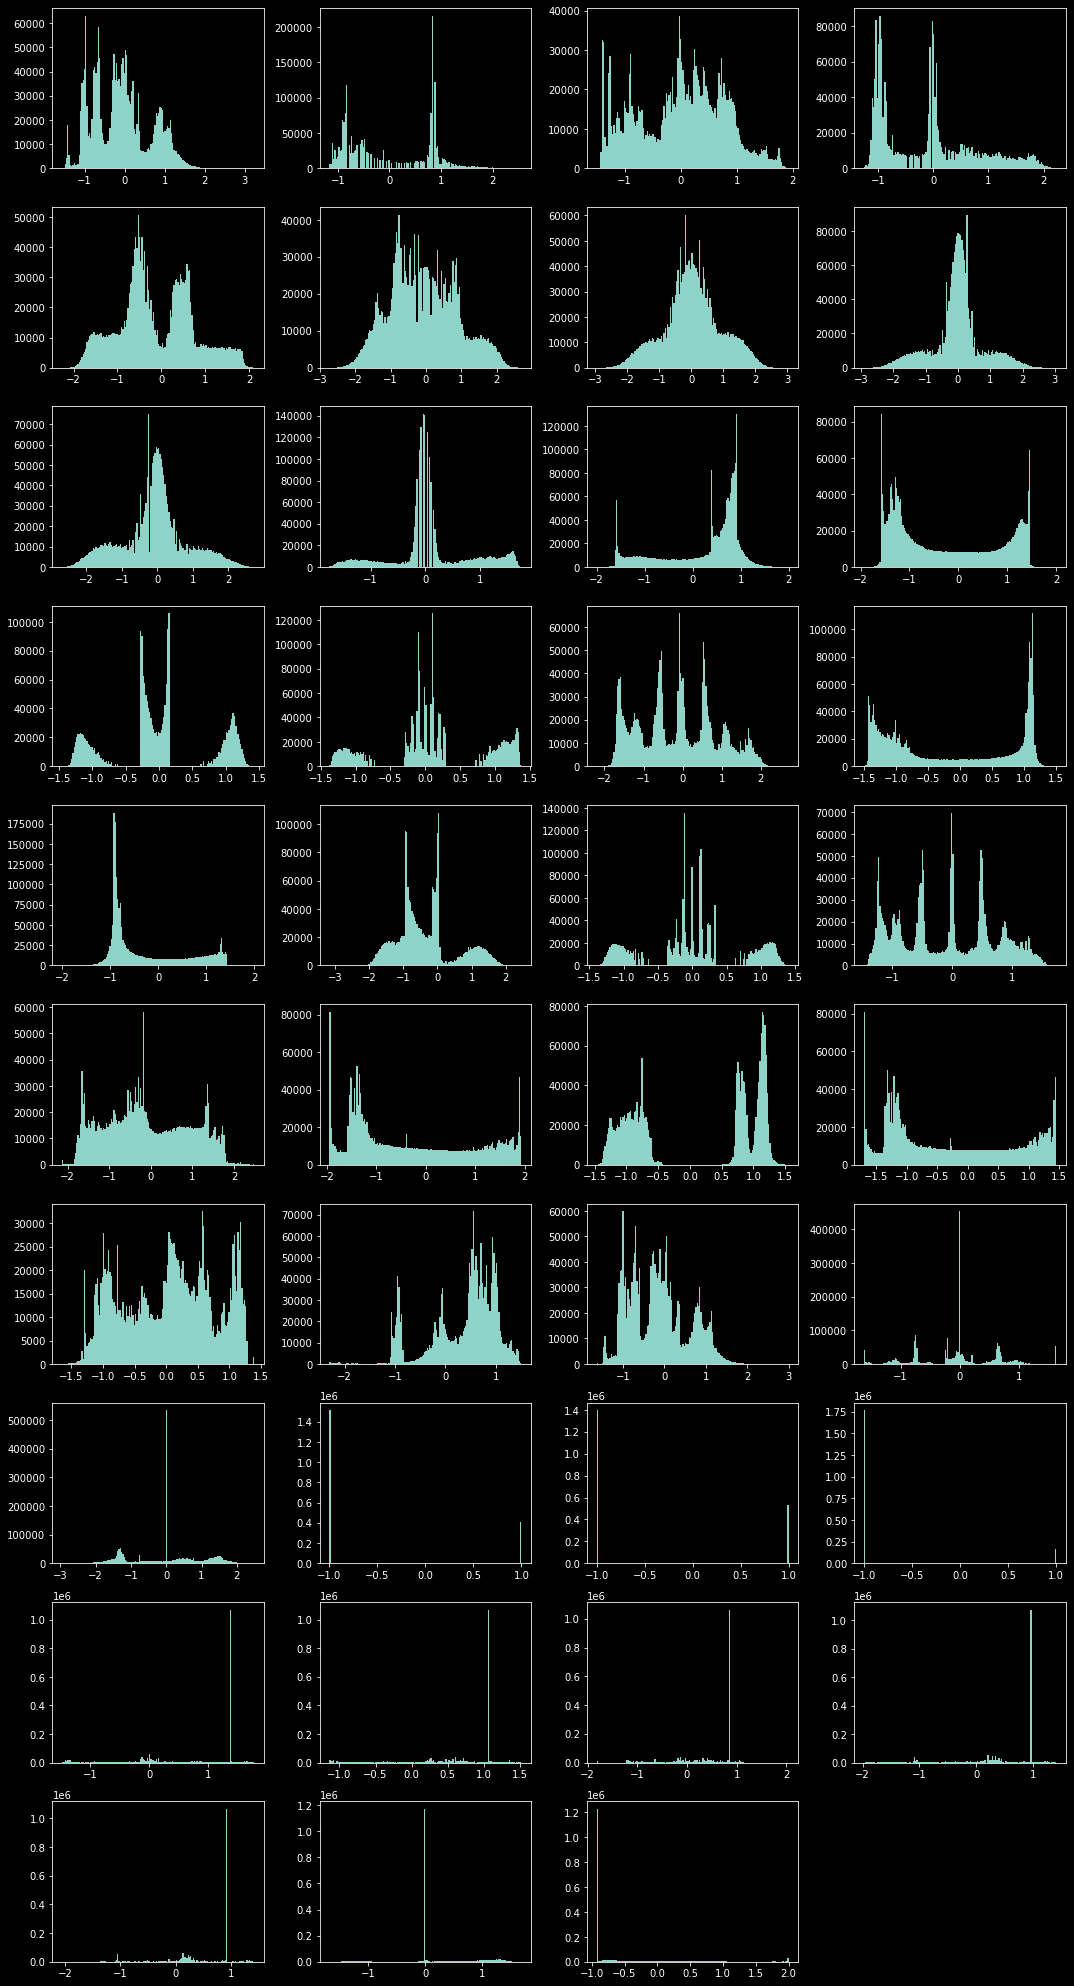

In [15]:
# plot preprocessed measurement features
plt.figure(figsize=(15,33))

num_feat = training_dataset['data_meas'].shape[1]
for ifeat in range(num_feat):
    print(f'Step {ifeat+1}/{num_feat}', end='\r')
    plt.subplot(12, 4, ifeat+1)
    plt.hist(training_dataset['data_meas'][:,ifeat], bins=150)

plt.tight_layout()
plt.show()

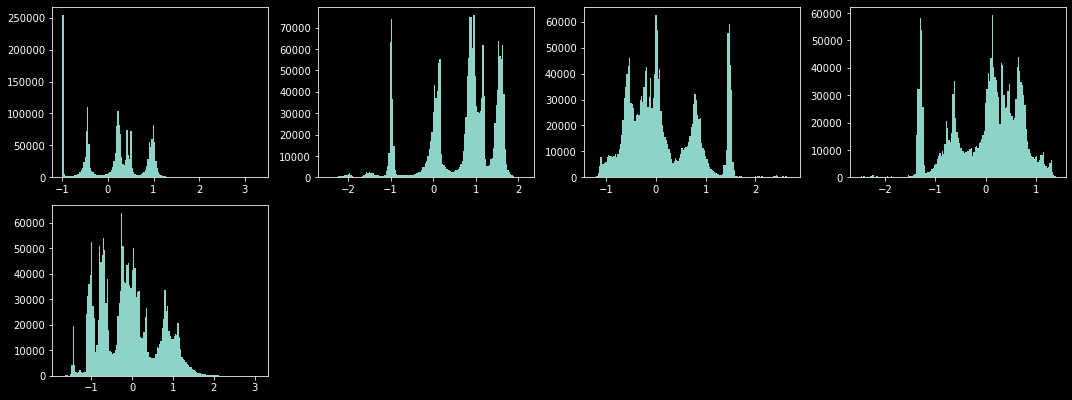

In [16]:
# plot preprocessed physical features
plt.figure(figsize=(15,33))

num_feat = training_dataset['data_sim'].shape[1]
for ifeat in range(num_feat):
    print(f'Step {ifeat+1}/{num_feat}', end='\r')
    plt.subplot(12, 4, ifeat+1)
    plt.hist(training_dataset['data_sim'][:,ifeat], bins=150)

plt.tight_layout()
plt.show()

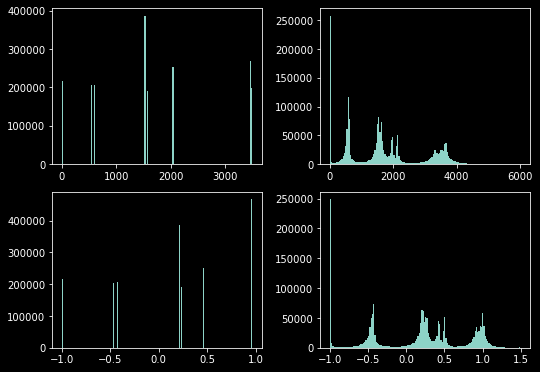

In [17]:
# plot outputs and predictions of physical model
plt.figure(figsize=(15,28))

# raw values
plt.subplot(11, 4, 1)
plt.hist(training_dataset['y_raw'], bins=150)
plt.subplot(11, 4, 2)
plt.hist(training_dataset['yhat_phys_raw'], bins=150)

# transformed values
plt.subplot(11, 4, 5)
plt.hist(training_dataset['y'], bins=150)
plt.subplot(11, 4, 6)
plt.hist(training_dataset['yhat_phys'], bins=150)

plt.tight_layout()
plt.show()

# Test data

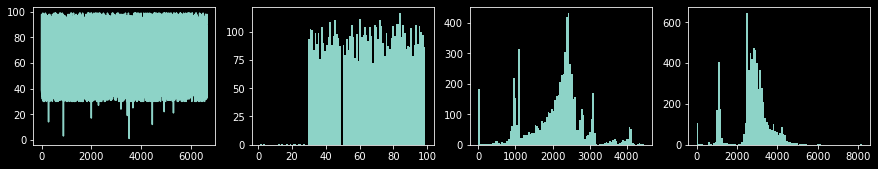

In [18]:
# get snippets characteristics and plot them
snippets_length, snippets_min, snippets_max = [], [], []

for fn_sim in filenames["sim_validation"]:
    df_sim = pd.read_csv(fn_sim)
    snippets_length.append(len(df_sim))
    snippets_min.append(min(df_sim['m_EstimdPayLoadLive_kg']))
    snippets_max.append(max(df_sim['m_EstimdPayLoadLive_kg']))
    
plt.figure(figsize=(15,33))
plt.subplot(11, 4, 1)
plt.plot(snippets_length)
plt.subplot(11, 4, 2)
plt.hist(snippets_length, bins=100)
plt.subplot(11, 4, 3)
plt.hist(snippets_min, bins=100)
plt.subplot(11, 4, 4)
plt.hist(snippets_max, bins=100)
plt.show()

In [19]:
# create hyptothetical outputs
# the numbers are collected from an initial model training by clustering the predicted values
# they could also be collected from the physical model (might be a bit less accurate)
# they have been manually updated during the training process by Ali

#IDEA: the validation test is used for model selection later on. 
# For final evalution of the method, an independent dataset (that is not considered during trainining) 
# should be considered.

y_raw_cand = np.transpose(np.expand_dims(np.array([1150, 2480, 3050, 3870]), axis=1))

In [20]:
# preprocess test data
validation_snippets = [] 

for fn, fn_sim in zip(filenames["data_validation"], filenames["sim_validation"]):
    
    # load measurements
    df_meas = load_csv_file(fn, rename_columns=rename_columns, reindex_columns=reindex_columns, round_time=True)
    data_meas = df_meas.to_numpy()[:,1:40]
    data_meas = preprocess_data(data_meas)
    
    # load outputs from physical model
    df_sim = load_csv_file(fn_sim, round_time=True)
    data_sim = df_sim.to_numpy()[:,1:]
    data_sim = preprocess_sim(data_sim)
    yhat_phys_raw = np.copy(df_sim.to_numpy()[:,1])
    yhat_phys_raw = np.clip(yhat_phys_raw, 0, 6000)

    # save everything needed
    data = np.hstack((data_meas, data_sim))
    data_dict = {'data':data}
    data_dict['data_torch'] = torch.tensor(data, dtype=torch.float, device=device)
    data_dict['y_raw_cand'] = np.repeat(y_raw_cand, len(data), axis=0)
    data_dict['y_cand'] = np.repeat(preprocess_output(y_raw_cand), len(data), axis=0)
    data_dict['yhat_phys_raw'] = yhat_phys_raw
    data_dict['fn'] = fn
    validation_snippets.append(data_dict)

In [21]:
print('Number of test snippets: %d'%len(validation_snippets))
print('Number of time points in first snippet: %d'%validation_snippets[0]['data'].shape[0])
print('Number of features: %d'%validation_snippets[0]['data'].shape[1])

Number of test snippets: 6645
Number of time points in first snippet: 39
Number of features: 44


# Training

In [22]:
class Model(nn.Module):
    def __init__(self, d_model=45, dim_feedforward=2048, device=device):
        super(Model, self).__init__()

        # encode time
        self.pos_enc = torch.unsqueeze(torch.tensor(np.linspace(0.01, 1, num=100), dtype=torch.float32, device=device), 1)
        
        # create mask for hiding future inputs
        self.src_mask = (torch.triu(torch.ones((100, 100), device=device)) == 1)
        self.src_mask = self.src_mask.transpose(0, 1).float()
        self.src_mask = self.src_mask.masked_fill(self.src_mask == 0, float('-inf'))
        self.src_mask = self.src_mask.masked_fill(self.src_mask == 1, float(0.0))
        
        # extract temporal features using transformers
        #IDEA: It is import to set the flag norm_first to True, otherwise the expected gradients
        # close near the output layer are larger hindering optimization
        # For more information, see https://arxiv.org/pdf/2002.04745.pdf
        self.encoder_layer1 = nn.TransformerEncoderLayer(d_model=d_model, nhead=1, dim_feedforward=dim_feedforward, dropout=0.0, batch_first=True, norm_first=True).to(device)
        self.encoder_layer2 = nn.TransformerEncoderLayer(d_model=d_model, nhead=1, dim_feedforward=dim_feedforward, dropout=0.0, batch_first=True, norm_first=True).to(device)
        self.encoder_layer3 = nn.TransformerEncoderLayer(d_model=d_model, nhead=1, dim_feedforward=dim_feedforward, dropout=0.0, batch_first=True, norm_first=True).to(device)
        
        # compute output based on temporal features using a linear layer
        self.linear_out = nn.Linear(3*d_model, 1).to(device)

    def forward(self, s, device=device, drop=False, training=False, debug=False):
        if type(s).__module__ == np.__name__:
            s = torch.tensor(s, dtype=torch.float, device=device)

        # add positional encoding
        pos_enc = self.pos_enc[:s.size()[1]].repeat(s.size()[0], 1, 1)
        s = torch.cat((s, pos_enc), 2)
        
        # propagate through three transformer modules in parallel
        v1 = self.encoder_layer1(s, self.src_mask[:s.size()[1],:s.size()[1]])
        v2 = self.encoder_layer2(s, self.src_mask[:s.size()[1],:s.size()[1]])
        v3 = self.encoder_layer3(s, self.src_mask[:s.size()[1],:s.size()[1]])
        v = torch.cat((v1, v2, v3), 2)

        # linear output layer
        out = self.linear_out(v)

        # clamp output when predicting
        if training == False:
            #IDEA: if predicted values are too large (i.e. physically not meaningful) clamp them 
            # during testing. Clamping should not be used during training, since it destroys
            # gradient information.
            return torch.clamp(out, min=-1, max=1.312)
        
        return out

In [23]:
model = Model()
model.eval()
print(f'Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

Number of parameters: 584755


In [24]:
def run():
    # optimize parameters of model
    last_checkpoint_step = epoch_length
    last_best_step = None
    last_save_step = epoch_length
    checkpoint_counter = 0
    save_counter = 0
    rmse_min = 1000
    lrs = []

    num_points = len(training_dataset['data_torch'])
    train_loss, rmse, rmse_raw, std, std_raw = [], [], [], [], []

    for _ in range(steps):
        # train model
        model.train()
        data, y = [], []

        for i in range(batchsize):
            n = np.random.randint(num_points-num_hist)
            data.append(training_dataset['data_torch'][n:n+num_hist])
            y.append(training_dataset['y_torch'][n:n+num_hist])
  
        data = torch.stack(data)
        y = torch.stack(y)
        yhat = model(data, training=True)
        loss = torch.sqrt(mse(yhat, y))
        train_loss.append(loss.detach().cpu().numpy())
        
        # evaluate model
        with torch.no_grad():
            model.eval()
            _rmse, _rmse_raw, _std, _std_raw = 0, 0, 0, 0
  
            for i in range(batchsize):
                n = np.random.randint(len(validation_snippets))
                x = validation_snippets[n]['data_torch'][None]
                y = validation_snippets[n]['y_cand']
                y_raw = validation_snippets[n]['y_raw_cand']
                yhat = model(x).detach().cpu().numpy()[0]
                
                _std += np.std(y) # std.dev. over each snippet
                _rmse += np.sqrt(np.mean(np.min(np.square(y - yhat), axis=1))) # cluster min
            
                yhat_raw = decode_output(yhat)
                _std_raw += np.std(yhat_raw) # same statistics as before on original space
                _rmse_raw += np.sqrt(np.mean(np.min(np.square(yhat_raw - y_raw), axis=1)))
        
        # collect statistics
        rmse.append(_rmse/batchsize)
        rmse_raw.append(_rmse_raw/batchsize)
        std.append(_std/batchsize)
        std_raw.append(_std_raw/batchsize)
        
        # smooth loss
        kernel_size = max(int(len(train_loss)*0.1), int(epoch_length*0.5))
        rmse_raw_conv = signal.convolve(rmse_raw[-kernel_size:], np.ones(kernel_size)/kernel_size, mode='valid')
        
        
        if _ >= epoch_length:
            # save at regular time points
            if (_-last_checkpoint_step) % (round(kernel_size/9)) == 0:
                checkpoint_counter += 1
                last_checkpoint_step = _
                torch.save(model.state_dict(), f'models/checkpoints/checkpoint-{checkpoint_counter % 9}')    
       
            # copy over current best solution
            if rmse_raw_conv[-1] < rmse_min:
                rmse_min = rmse_raw_conv[-1]
                last_best_step = round(_+1 - kernel_size/2)
                last_best_epoch = round(last_best_step/epoch_length, 1)
                if last_save_step != last_checkpoint_step:
                    last_save_step = last_checkpoint_step
                    save_counter = checkpoint_counter
                    copy_tree('models/checkpoints', f'models/trained_ensemble')
                    
            # early stopping criterion
            if (len(train_loss) - last_best_step) > max(0.4*len(train_loss), 4*epoch_length):
                break
        
        # perform parameter optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if lr_finder == True:
            lrs.append(scheduler.get_last_lr())
            scheduler.step()
        
        # print out
        if _ > epoch_length:
            print(f'Step: {_+1}    Epoch: {round((_+1)/epoch_length, 1)}    min RMSE: {round(rmse_min, 2)}   at Epoch: {last_best_epoch}   at Step: {last_best_step}   Model-No: {(save_counter-4) % 9}   ', end='\r')
        else:
            print(f'Step: {_+1}    Epoch: {round((_+1)/epoch_length, 1)}', end='\r')
     
    # write statistics out
    rv = {}
    rv['train_loss'] = train_loss
    rv['rmse'] = rmse 
    rv['rmse_raw'] = rmse_raw
    rv['std'] = std
    rv['std_raw'] = std_raw
    rv['rmse_min'] = rmse_min
    rv['save_counter'] = save_counter
    rv['last_best_step'] = last_best_step
    if lr_finder==True: rv['lrs'] = lrs 
    model.eval()
    return rv

## Find Best Learning Rate

In [25]:
# settings for finding best learning rate
batchsize = 16 
num_hist = 100
mse = nn.MSELoss()

epoch_length = int(len(training_dataset['data_torch'])/(num_hist*batchsize))
min_steps = 300
max_steps = 10000
steps = min(max_steps, max(min_steps, epoch_length))

optimizer = torch.optim.RAdam(model.parameters(), lr=1e-8)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1e6**(1/steps)) 
lr_finder = True

stats_lr = run()

Learning Rate: 5.564476246478681e-06
Learning Rate: 1.1089836027563403e-05
Learning Rate: 2.1849136415401033e-05


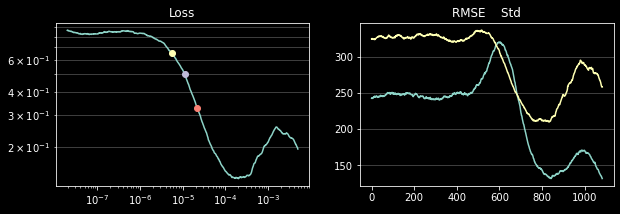

In [26]:
# extract best learning rate
kernel_size = int(len(stats_lr['train_loss'])*0.1)
lrs = stats_lr['lrs'][int(np.floor(kernel_size/2))-1:-int(np.floor(kernel_size/2))]

# training loss is smoothed
train_loss_avg = signal.convolve(np.array(stats_lr['train_loss']), np.ones(kernel_size)/kernel_size, mode='valid')

# gradient of smoothed loss is computed and smoothed again
train_loss_gradient_avg = np.gradient(train_loss_avg)
train_loss_gradient_avg = signal.convolve(train_loss_gradient_avg, np.ones(kernel_size)/kernel_size, mode='valid')
idx_min = np.argmin(train_loss_gradient_avg) # steepest descent

# plot training loss 
plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1).title.set_text(f'Loss')
plt.plot(lrs, train_loss_avg)
plt.plot(lrs[idx_min], train_loss_avg[idx_min], 'o')
plt.plot(lrs[idx_min+int(kernel_size/2)], train_loss_avg[idx_min+int(kernel_size/2)], 'o') 
plt.plot(lrs[idx_min+kernel_size-1], train_loss_avg[idx_min+kernel_size-1], 'o') 
plt.semilogx()
lr_opt = lrs[idx_min+kernel_size-1][0] # optimum learning rate (shift to right due to smoothing)
print(f'Learning Rate: {lrs[idx_min][0]}')
print(f'Learning Rate: {lrs[idx_min+int(kernel_size/2)][0]}')
print(f'Learning Rate: {lrs[idx_min+kernel_size-1][0]}')
plt.semilogy()
plt.grid(which='both', axis='y', alpha=0.3)

# plot test statistics on untransformed data
plt.subplot(1, 2, 2).title.set_text(f'RMSE    Std')
plt.plot(signal.convolve(stats_lr['std_raw'], np.ones(kernel_size)/kernel_size, mode='valid'))
plt.plot(signal.convolve(stats_lr['rmse_raw'], np.ones(kernel_size)/kernel_size, mode='valid'))
plt.grid(which='both', axis='y', alpha=0.3)
plt.show()

## Optimize model

In [27]:
lr_finder = False
num_epochs = 100 # for final run, consider movin up to 500
steps = num_epochs*epoch_length
model = Model()
optimizer = torch.optim.RAdam(model.parameters(), lr=lr_opt)

stats_opt = run()
save_counter = stats_opt['save_counter']
last_best_step = stats_opt['last_best_step']

Min RMSE: 98.68, at Step: 73542
Smoothed Min RMSE: 92.36, at Step: 60843


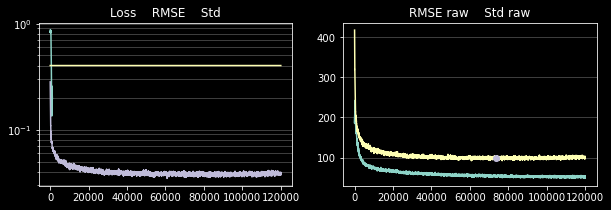

In [28]:
rmse_min = stats_opt['rmse_min']
rmse_raw_avg = signal.convolve(stats_opt['rmse_raw'], np.ones(kernel_size)/kernel_size, mode='valid')
print(f'Min RMSE: {round(rmse_min, 2)}, at Step: {round(last_best_step-kernel_size/2)}')
print(f'Smoothed Min RMSE: {round(min(rmse_raw_avg), 2)}, at Step: {np.argmin(rmse_raw_avg)}')

plt.figure(figsize=(10,3))
# plot training loss
plt.subplot(1, 2, 1).title.set_text(f'Loss    RMSE    Std')
plt.plot(train_loss_avg)
plt.plot(signal.convolve(stats_opt['std'], np.ones(kernel_size)/kernel_size, mode='valid'))
plt.plot(signal.convolve(stats_opt['rmse'], np.ones(kernel_size)/kernel_size, mode='valid'))
plt.semilogy()
plt.grid(which='both', axis='y', alpha=0.3)

# plot statistics on untransformed data
plt.subplot(1, 2, 2).title.set_text(f'RMSE raw    Std raw')
plt.plot(signal.convolve(stats_opt['std_raw'], np.ones(kernel_size)/kernel_size, mode='valid'))
plt.plot(signal.convolve(stats_opt['rmse_raw'], np.ones(kernel_size)/kernel_size, mode='valid'))
plt.plot(last_best_step-kernel_size/2, rmse_raw_avg[round(last_best_step-kernel_size/2)], 'o')
plt.grid(which='both', axis='y', alpha=0.3)
plt.show()

# Predictions

In [29]:
ensemble = False
num_hist = 100 

In [30]:
def average_n(s, n=100):
    #IDEA: smooth prediction over n time steps
    # how-to: average over last n positions or fewer if otherwise not possible
    if isinstance(object, list) or s.ndim < 3:
        new = np.empty(len(s))
        for _ in range(len(s)):
            new[_] = np.mean(s[max(0, _+1-n):_+1])
        return new
    else:
        if s.ndim == 3:
            new = np.ones_like(s)
            for _ in range(s.shape[0]):
                for i in range(s.shape[1]):
                    new[_][i] = np.mean(s[_][max(0, i+1-n):i+1])
            return new

In [31]:
def predict(x, ensemble=True):
    #IDEA: smooth prediction by using an ensemble of methods
    # if ensemble=True (default), use a model ensemble for prediction. Otherwise, use the model specified in the variable
    # save counter
    if ensemble: 
        checkpoints = range(9)
    else:
        checkpoints = [save_counter]
        
    out_ensemble = []
    out_dec_ensemble = []
    for i in checkpoints:
        model.load_state_dict(torch.load(f'models/trained_ensemble/checkpoint-{(i-0) % 9}'))
        out = model(x).detach().cpu().numpy()
        out_dec = decode_output(out)
        
        out_ensemble.append(out)
        out_dec_ensemble.append(out_dec)
        
    out_ensemble = np.mean(np.array(out_ensemble), axis=0)
    out_dec_ensemble = np.mean(np.array(out_dec_ensemble), axis=0)
    return out_ensemble, out_dec_ensemble

In [32]:
# predict training data
yhat = []
yhat_raw = []

batchsize = 506 
num_batches = math.floor(len(training_dataset['data_torch'])/num_hist/batchsize)
num_total = num_hist * batchsize * num_batches

for ibatch in range(num_batches):
    print(f'{ibatch+1}/{num_batches}', end='\r')
    data = training_dataset['data_torch'][num_hist*batchsize*ibatch:num_hist*batchsize*(ibatch+1)]
    data = torch.reshape(data, (batchsize, num_hist, -1))
    _yhat, _yhat_raw = predict(data, ensemble=ensemble)
    yhat.extend(_yhat)
    yhat_raw.extend(_yhat_raw)

yhat = np.reshape(yhat, (num_batches * batchsize, num_hist))
yhat_raw = np.reshape(yhat_raw, (num_batches * batchsize, num_hist))

In [33]:
# statistics on transformed outputs
yhat_std = np.std(yhat, axis=1)
y = np.reshape(training_dataset['y'][:num_total], (batchsize * num_batches, num_hist))
rmse = np.sqrt(np.mean(np.square(y-yhat), axis=1))
yhat_flatten = yhat.flatten()

# statistics on raw outputs
yhat_raw_std = np.std(yhat_raw, axis=1)
y_raw = np.reshape(training_dataset['y_raw'][:num_total], (batchsize * num_batches, num_hist))
rmse_raw = np.sqrt(np.mean(np.square(y_raw - yhat_raw), axis=1))
yhat_raw_flatten = yhat_raw.flatten()

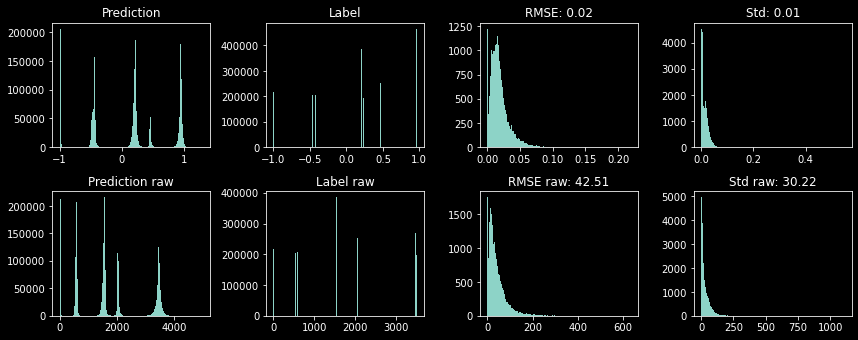

In [34]:
plt.figure(figsize=(15,28))

# predictions in transformed space
plt.subplot(12, 5, 1).title.set_text(f'Prediction')
plt.hist(yhat_flatten, bins=150)
plt.subplot(12, 5, 2).title.set_text('Label')
plt.hist(training_dataset['y'], bins=150)
plt.subplot(12, 5, 3).title.set_text(f'RMSE: {str(round(np.mean(rmse), 2))}')
plt.hist(rmse, bins=150)
plt.subplot(12, 5, 4).title.set_text(f'Std: {str(round(np.mean(yhat_std), 2))}')
plt.hist(yhat_std, bins=150)

# predictions in original space
plt.subplot(12, 5, 6).title.set_text(f'Prediction raw')
plt.hist(yhat_raw_flatten, bins=150)
plt.subplot(12, 5, 7).title.set_text('Label raw')
plt.hist(training_dataset['y_raw'], bins=150)
plt.subplot(12, 5, 8).title.set_text(f'RMSE raw: {str(round(np.mean(rmse_raw), 2))}')
plt.hist(rmse_raw, bins=150)
plt.subplot(12, 5, 9).title.set_text(f'Std raw: {str(round(np.mean(yhat_raw_std), 2))}')
plt.hist(yhat_raw_std, bins=150)

plt.tight_layout()
plt.show()

In [35]:
# predictions on test data 
yhat_raw, yhat_phys_raw, std, rmse, yhat_raw_avg, std_avg, rmse_avg = [], [], [], [], [], [], []

num_validation_snippets = len(validation_snippets)
for _, validation_snippet in enumerate(validation_snippets):
    
    print(f'{_+1}/{num_validation_snippets}', end='\r')
    _, _yhat_raw = predict(validation_snippet['data_torch'][None], ensemble=ensemble)
    _y_raw = validation_snippet['y_raw_cand']
    _yhat_phys_raw = validation_snippet['yhat_phys_raw']
    
    yhat_raw.extend(_yhat_raw.flatten())
    yhat_phys_raw.extend(_yhat_phys_raw.flatten())
    std.extend(np.std(_yhat_raw, axis=1).flatten())
    rmse.extend(np.sqrt(np.mean(np.min(np.square(_y_raw - _yhat_raw), axis=2), axis=1)).flatten())
    
    _yhat_raw_avg = average_n(_yhat_raw)
    yhat_raw_avg.extend(_yhat_raw_avg.flatten())
    
    std_avg.extend(np.std(_yhat_raw_avg, axis=1).flatten())
    rmse_avg.extend(np.sqrt(np.mean(np.min(np.square(_y_raw - _yhat_raw_avg), axis=2), axis=1)).flatten())

yhat_phys_raw = np.array(yhat_phys_raw)

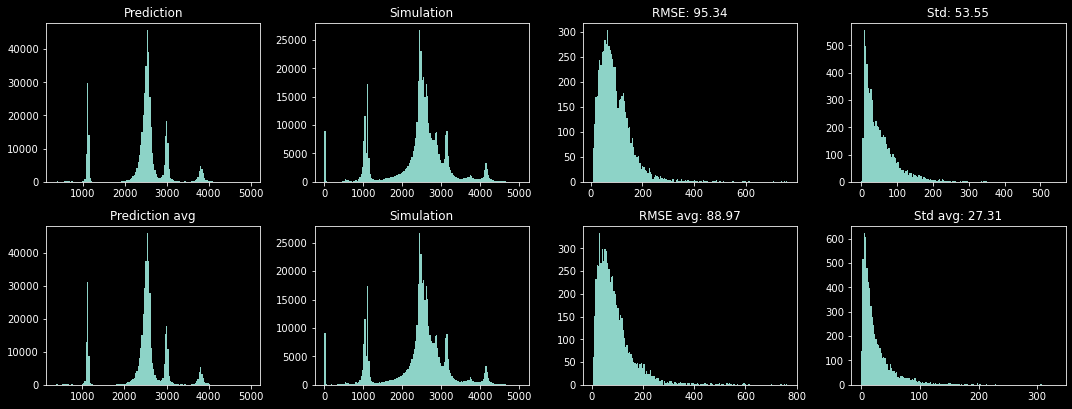

In [36]:
plt.figure(figsize=(15,45))

plt.subplot(16, 4, 1).title.set_text('Prediction')
plt.hist(yhat_raw, bins=150)
plt.subplot(16, 4, 2).title.set_text('Simulation')
plt.hist(yhat_phys_raw[yhat_phys_raw < 5000], bins=150)
# plt.hist(np.repeat(np.array([0, 1150, 2480, 2570, 3050, 3870, 5000]), 500, axis=0), bins=150)
plt.subplot(16, 4, 3).title.set_text(f'RMSE: {str(round(np.mean(rmse), 2))}')
plt.hist(rmse, bins=150)
plt.subplot(16, 4, 4).title.set_text(f'Std: {str(round(np.mean(std), 2))}')
plt.hist(std, bins=150)

plt.subplot(16, 4, 5).title.set_text('Prediction avg')
plt.hist(yhat_raw_avg, bins=150)
# plt.hist(np.repeat(np.array([0, 1150, 2480, 2570, 3050, 3870, 5000]), 35000, axis=0), bins=150)
plt.subplot(16, 4, 6).title.set_text('Simulation')
plt.hist(yhat_phys_raw[yhat_phys_raw < 5000], bins=150)
plt.subplot(16, 4, 7).title.set_text(f'RMSE avg: {round(np.mean(rmse_avg), 2)}')
plt.hist(rmse_avg, bins=150)
plt.subplot(16, 4, 8).title.set_text(f'Std avg: {str(round(np.mean(std_avg), 2))}')
plt.hist(std_avg, bins=150)


plt.tight_layout()
plt.show()

# Creating Plots

In [37]:
# load data
y_raw_list, time_list, yhat_phys_raw_list, data_torch_list = [], [], [], []
num_files = len(filenames["data_training_org"])
for _, (fn, fn_sim) in enumerate(zip(filenames["data_training_org"], filenames["sim_training_org"])):
    print(f'Step {_+1}/{num_files}', end='\r')
    # load inputs
    df_meas = load_csv_file(fn, rename_columns=rename_columns, reindex_columns=reindex_columns, round_time=True)
    data_meas = df_meas.to_numpy()[:,1:40]
    data_meas = preprocess_data(data_meas)
    
    # load physical outputs
    df_sim = load_csv_file(fn_sim, round_time=True)
    data_sim = df_sim.to_numpy()[:,1:]
    data_sim = preprocess_sim(data_sim)
    
    # stack together
    data = np.hstack((data_meas, data_sim))
    data_torch = torch.tensor(data, dtype=torch.float, device=device)
    
    # predicted output from physical model
    yhat_phys_raw = np.copy(df_sim.to_numpy()[:,1])
    yhat_phys_raw = np.clip(yhat_phys_raw, 0, 6000)
    
    # true output
    y_raw = np.copy(df_meas.to_numpy())[:,41] + np.copy(df_meas.to_numpy())[:,40]
    time = np.copy(df_sim.to_numpy()[:,0])

    y_raw_list.append(y_raw)
    time_list.append(time)    
    yhat_phys_raw_list.append(yhat_phys_raw)
    data_torch_list.append(data_torch)

In [38]:
# run predictions
batchsize = 200

yhat_raw_list = []
yhat_raw_avg_list = []
for ifile in range(num_files):
    print(f'Step {ifile+1}/{num_files}', end='\r')
    # batch trajectory in snippets of length 200 for efficiency
    n = math.floor(data_torch_list[ifile].size()[0]/num_hist)
    n_temp = n
    yhat_raw = []
    for i in range(math.ceil(n/batchsize)):
        if n_temp >= batchsize:
            data = data_torch_list[ifile][batchsize*num_hist*i:batchsize*num_hist*(i+1)]
            data = torch.reshape(data, (batchsize, num_hist, -1))
            n_temp -= batchsize
        else:
            data = data_torch_list[ifile][batchsize*num_hist*i:batchsize*num_hist*i+100*n_temp]
            data = torch.reshape(data, (n_temp, num_hist, -1))
            
        _, _yhat_raw = predict(data, ensemble=ensemble)
        yhat_raw.append(_yhat_raw)

    yhat_raw = np.vstack(np.vstack(yhat_raw))
    yhat_raw_list.append(yhat_raw)
    yhat_raw_avg = average_n(yhat_raw)
    yhat_raw_avg_list.append(yhat_raw_avg)

In [39]:
# plot
plt.style.use('default')
plt.figure(figsize=(10,5))

for _ in range(num_files):
    print(f'Step {_+1}/{num_files}', end='\r')
    N = len(yhat_raw_avg_list[_])
    plt.plot(time_list[_][num_hist:N], yhat_phys_raw_list[_][num_hist:N], label='phys sim', alpha=0.9)
    plt.plot(time_list[_][num_hist:N], yhat_raw_avg_list[_][num_hist:N], label='prediction')
    plt.plot(time_list[_][num_hist:N], y_raw_list[_][num_hist:N], label='meas')
    plt.xlabel('Time [s]')
    plt.ylabel('Payload [kg]')
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.savefig(f'out/figures/{filenames["data_training_org"][_][21:-4]}.png', bbox_inches='tight')
    plt.clf()

plt.style.use('dark_background')

<Figure size 1000x500 with 0 Axes>

# Create Submission

In [40]:
# create zip file in order to upload predictions to leaderboard

num_test_snippets = len(filenames["data_validation"])
for _, (fn, fn_sim) in enumerate(zip(filenames["data_validation"], filenames["sim_validation"])):
    print(f'{_+1}/{num_test_snippets}', end='\r')
    fn_pred = 'pred-' + fn[21:]
    # load inputs
    df_meas = load_csv_file(fn, rename_columns=rename_columns, reindex_columns=reindex_columns, round_time=True)
    data_meas = df_meas.to_numpy()[:,1:40]
    data_meas = preprocess_data(data_meas)

    # load physical outputs
    df_sim = load_csv_file(fn_sim, round_time=True)
    data_sim = df_sim.to_numpy()[:,1:]
    data_sim = preprocess_sim(data_sim)
    
    # stack together
    data = np.hstack((data_meas, data_sim))
    data_torch = torch.tensor(data, dtype=torch.float, device=device)
    
    # predict
    _, yhat_raw = predict(data_torch[None], ensemble=ensemble)
    df_meas['prediction'] = average_n(yhat_raw[0])
    
    # save
    df_pred = df_meas[['time', 'prediction']]
    df_pred.to_csv('out/predictions/' + fn_pred, index=False)

shutil.make_archive('out/predictions', 'zip', 'out/predictions/')

'C:\\Users\\rab2rng\\Documents\\PayloadEstimation\\Ali_solution\\out\\predictions.zip'